In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [75]:
from scipy import stats
from scipy.stats import norm, skew

In [205]:
train = pd.read_csv('../data/d_train.csv', index_col='id', encoding='gbk')
test = pd.read_csv('../data/d_test_A_20180102.csv', index_col='id', encoding='gbk')

In [206]:
new_columns = ['F{0}'.format(i+1) for i in range(train.shape[1])]
new_columns[-1] = 'blood_sugar'
feature_map = pd.Series(index=new_columns, data=train.columns)
train.columns = new_columns
test.columns = new_columns[:-1]

In [207]:
n_train = train.shape[0]
n_test = test.shape[0]
y_train = train.blood_sugar.values

In [208]:
all_data = pd.concat([train.iloc[:, :-1], test], axis=0, join='outer').reset_index(drop=True)
# 2是缺失值
sex_dict = {u'男':'male', u'女':'female'}
all_data.F1 = all_data.F1.apply(lambda x: sex_dict[x] if x in sex_dict.keys() else 'other')

In [209]:
all_data.F1.value_counts()

male      3328
female    3313
other        1
Name: F1, dtype: int64

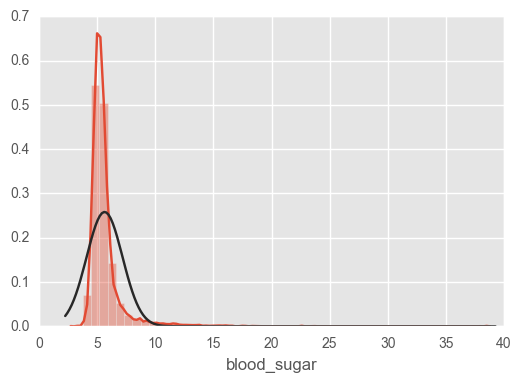

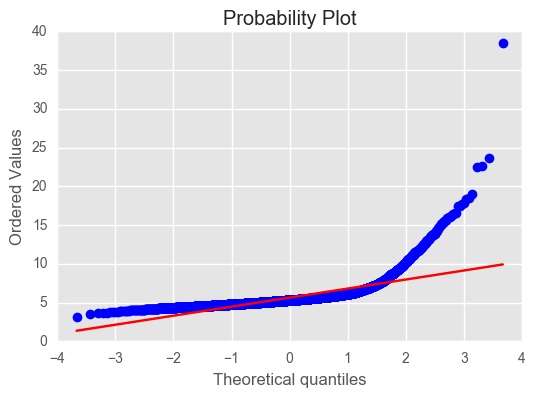

In [210]:
sns.distplot(train.blood_sugar , fit=norm, norm_hist=False)
plt.show()

fig = plt.figure()
res = stats.probplot(train.blood_sugar, plot=plt)
plt.show()

In [211]:
train.blood_sugar = np.log1p(np.log1p(train.blood_sugar))

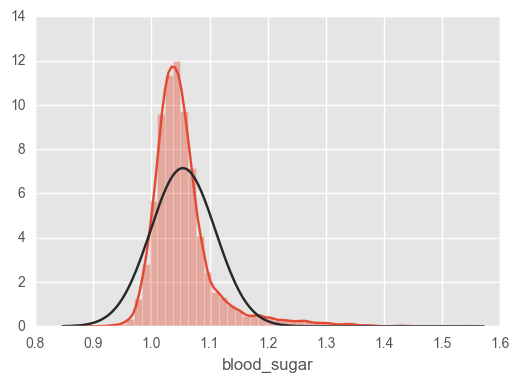

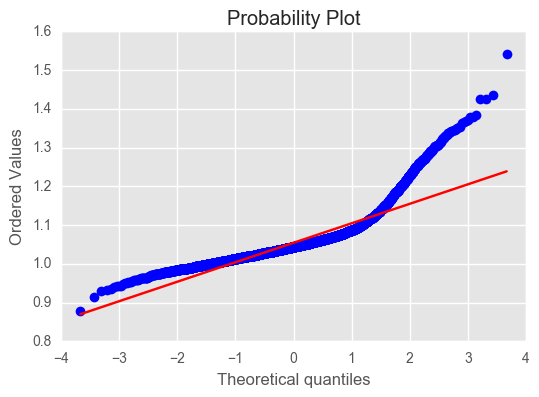

In [212]:
sns.distplot(train.blood_sugar , fit=norm, norm_hist=False)
plt.show()

fig = plt.figure()
res = stats.probplot(train.blood_sugar, plot=plt)
plt.show()

In [213]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing_Ratio' :all_data_na})
missing_data

,Missing_Ratio
F22,76.934658
F23,76.934658
F19,76.934658
F20,76.934658
F21,76.934658
F16,23.667570
F17,23.667570
F18,23.667570
F5,21.168323
F6,21.168323


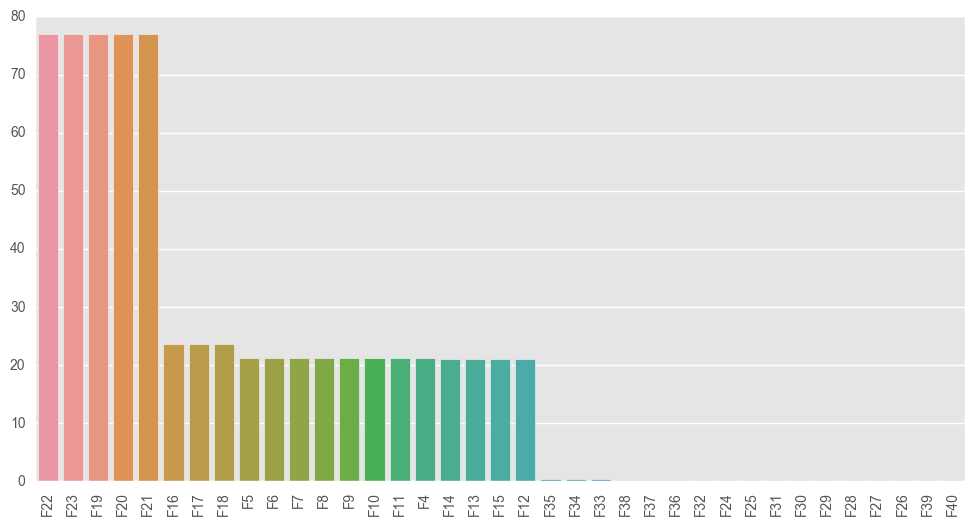

In [214]:
f, ax = plt.subplots(figsize=(12, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.show()

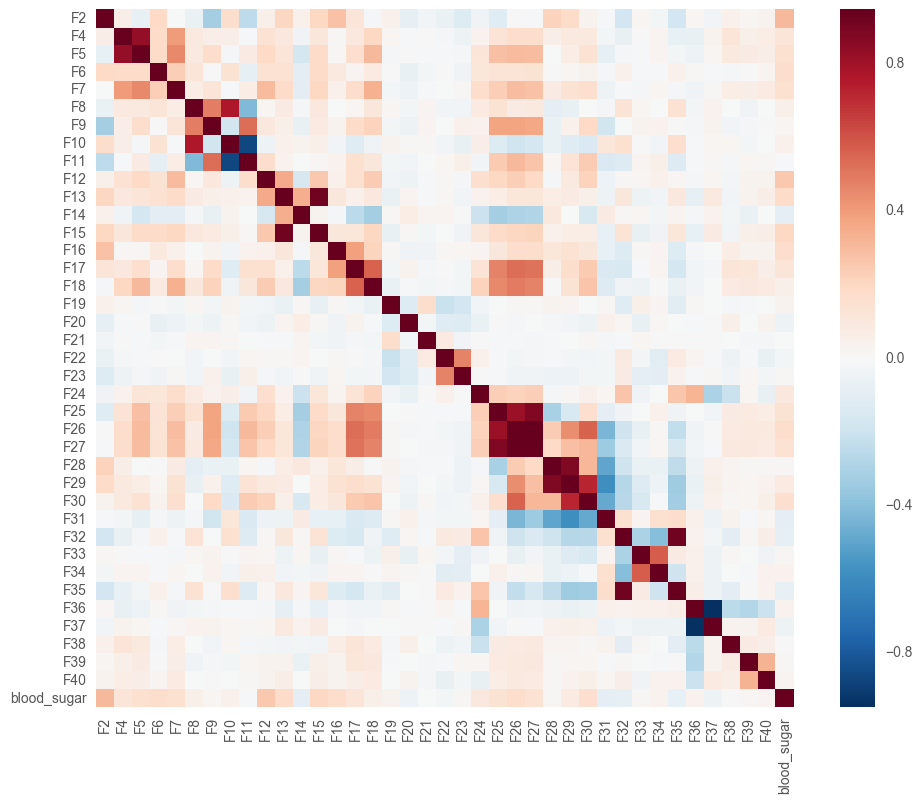

In [215]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [216]:
# F3: 日期
drop_feature_list = ['F3', 'F19', 'F20', 'F21', 'F22', 'F23']
all_data = all_data.drop(drop_feature_list, axis=1)

In [217]:
all_data.iloc[:, 1:] = all_data.iloc[:, 1:].apply(lambda x: x.fillna(x.mean()))

In [218]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing_Ratio' :all_data_na})
missing_data

,Missing_Ratio


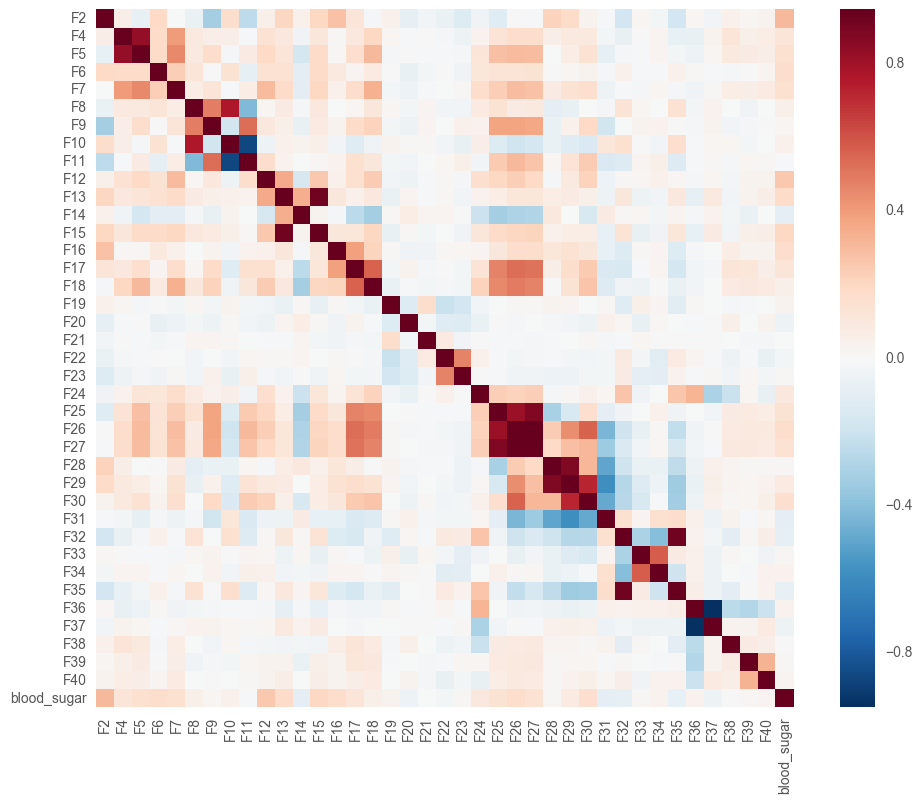

In [219]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

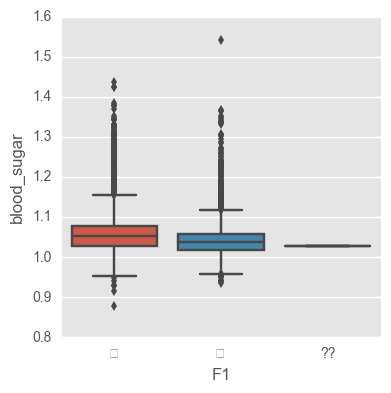

In [220]:
sns.factorplot(x="F1", y="blood_sugar", kind="box", data=train)
plt.show()

In [221]:
# Check the skew of all numerical features
skewed_feats = all_data.iloc[:, 1:].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
F12,6.734337
F7,5.186482
F5,4.266116
F4,4.240761
F39,2.809199
F40,1.440849
F35,1.218673
F32,0.998925
F24,0.746648
F38,0.691149


In [222]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 33 skewed numerical features to Box Cox transform


In [223]:
all_data = pd.get_dummies(all_data)

In [224]:
train = all_data[:n_train]
test = all_data[n_train:]

In [225]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [226]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return rmse

In [227]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

In [228]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.001, random_state=11))

In [229]:
line = make_pipeline(RobustScaler(), LinearRegression())

In [230]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=2))

In [231]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=0.25)

In [232]:
GBoost = GradientBoostingRegressor(n_estimators=3000, 
                                   learning_rate=0.05,
                                   max_depth=4, 
                                   max_features='sqrt',
                                   min_samples_leaf=15, 
                                   min_samples_split=10, 
                                   loss='huber', 
                                   random_state =3)

In [233]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.05, 
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             reg_alpha=0.4640, 
                             reg_lambda=0.8571,
                             subsample=0.5213, 
                             silent=1,
                             seed=4, 
                             nthread = -1)

In [234]:
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=5,
                              learning_rate=0.05, 
                              n_estimators=720,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              bagging_freq = 5, 
                              feature_fraction = 0.2319,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf =6, 
                              min_sum_hessian_in_leaf = 11)

In [235]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0506 (0.0028)



In [236]:
score = rmsle_cv(ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Ridge score: 0.0506 (0.0028)



In [237]:
score = rmsle_cv(line)
print("\nLine score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Line score: 0.0507 (0.0028)



In [238]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0506 (0.0027)



In [239]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.0504 (0.0016)



In [240]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.0508 (0.0027)



In [241]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.0497 (0.0029)



In [242]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.0496 (0.0030)



In [186]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [187]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0492 (0.0028)



In [243]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models =base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=0)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, hold_out_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[hold_out_index])
                out_of_fold_predictions[hold_out_index, i] = y_pred
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([
                model.predict(X) 
                for model in base_models]).mean(axis=1)
                    for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [244]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

D:\Program Files\Anaconda2\envs\xgboost\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Stacking Averaged models score: 0.0495 (0.0026)


In [191]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [192]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0432254365042


In [193]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0466137448601


In [194]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0466137448601


In [195]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0404233369596


In [196]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
            xgb_train_pred*0.15 + 
            lgb_train_pred*0.15 ))

RMSLE score on train data:
0.043015529688


In [197]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [198]:
sub = pd.DataFrame()
sub['blood_sugar'] = ensemble
sub.to_csv('../data/submission.csv',index=False, header=None)